# Implémentation du schéma de Rusanov

Voici le code à partir duquel nous avons obtenu les graphes du rapport. Ce code permet aussi de générer des fichier .gif et ainsi de visualiser les évolutions (hauteur d'eau et débit) au cours du temps.

## Importations

In [1]:
import math as math # Pour les fonctions math
import matplotlib.pyplot as plt # Pour l'affichage des graphes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import numpy as np # Pour les tableaux numpy
import imageio # Pour faire des .gif

## Paramètres du problème

In [2]:
g=1 # Constante gravitationnelle

xMin=0 # Bord gauche du domaine
xMax=100 # Bord droit du domaine

N=512 # Nombre de points (strictement à l'intérieur)
# Donc au total, on considère N+2 points avec les bords
h=(xMax-xMin)/(N+1) # Pas du maillage spatial

Tmax=10 # Temps final de la simulation
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

## Conditions initiales et Topographie

Dans la cellule ci-dessous, nous définissons la discrétisation de l'axe des abscisses $\textbf{X}$, ainsi que la topographie $\textbf{Z}$ et les profils initiaux de la hauteur d'eau $h$ et du débit $q$. Le code en commentaire correspond à différentes initialisations possibles. Pour le suite, notons 
$\textbf{U}=
\begin{pmatrix}
   h \\
   q \\
\end{pmatrix}
\in\mathbb{R}^{2}$ 
le vecteur inconnu.

In [3]:
X=np.linspace(xMin,xMax,N+2) # Discrétisation de [xMin, xMax]
U=np.ones([2,N+2]) # discrétisation du vecteur (h, q)
Uprime=np.zeros([2,N+2]) # Va servir d'intermédiaire de calcul
Z=np.zeros(N+2) # Discrétisation du fond Z
 
# Définitions de Z --------------------------------------------

# Conditions initiales avec Z en créneau :
# Z[(N+2)//5:2*(N+2)//5]=0.3
# Z[3*(N+2)//5:4*(N+2)//5]=0.3

# Conditions initiales avec Z en bosse C infini :
# Z=1/(1+.1*(X-50)**2)

# Conditions initiales avec Z en escalier descendant :
# Z[0:(N+2)//4]=.75
# Z[(N+2)//4:3*(N+2)//4]=0.25

# Conditions initiales avec Z en tangente hyperbolique :
# Z=np.tanh(5-X)/2+.5


# Définitions du h initial ------------------------------------

# Hauteur de l'eau en escalier 
U[0,0:(N+2)//3]=3-Z[:(N+2)//3]
# U[0,(N+2)//3:N+2]=1.25-Z[(N+2)//3:N+2]

# Hauteur de l'eau constante
# U[0,:]=1-Z

# Hauteur de l'eau en bosse
# U[0,:]=1+2/(1+.05*(X-50)**2)-Z


# Définitions du q initial ------------------------------------

# Débit de l'eau constant
U[1,:]=0

## Nombre de sauvegardes durant la simulation

Quelques variables qui vont nous servir pour enregistrer des étapes de la simulation, sans pour autant les sauvegarder toutes. Sans ça, le nombre d'images à sauver deviendrait vite trop important.

In [4]:
nSauvegarde=10 # Nombre de sauvegardes au cours de la simulation
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
j=0 # Nombre de sauvegardes déjà effectuées

## Affichage des images

La fonction ci-dessous permet de gérer l'affichage de la solution. Elle est suivie d'un test. Les graphes qui s'affichent sont ceux de $h$ et $q$ à $t=0$.

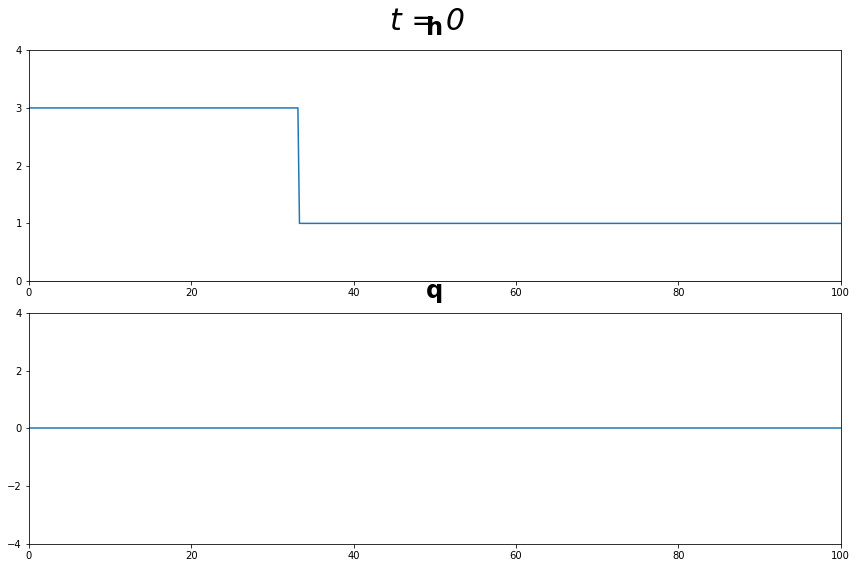

In [5]:
def affiche_U(t):
    
    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig,axs=plt.subplots(2,1,figsize=(12,8))
    
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
    fig.tight_layout()
    
    plt.rc('font', size=20)
    
    h_z=U[0,:]+Z
    
    axs[0].plot(X,h_z)
    axs[0].set_title("h",fontweight="bold",pad=15)
    axs[0].set_xlim([xMin,xMax])
    axs[0].set_ylim([0,4])
    axs[0].fill_between(X,Z,step="pre",alpha=0.5,color="grey")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q", fontweight="bold",pad=15)
    axs[1].set_xlim([xMin,xMax])
    axs[1].set_ylim([-4,4])
    
    # axs[1].set_xlabel("Quantité d'eau : "+str(round(sum(U[0,:])*h,2)))
    
    plt.show()

affiche_U(0) # Test d'affichage de la solution

## Sauvegarde des images

_enregistre_U_ effectue un traitement identique à _affiche_U_. La seule différence est qu'elle enregistre le plot dans le répertoire courant plutôt que de l'afficher.

In [6]:
def enregistre_U(n,t):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
      
    fig,axs=plt.subplots(2,1,figsize=(12,8))
    
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
    fig.tight_layout()
    
    plt.rc('font',size=20)
    
    h_z = U[0,:]+Z
    
    axs[0].plot(X,h_z)
    axs[0].set_title("h", fontweight="bold", pad=15)
    axs[0].set_xlim([xMin,xMax])
    axs[0].set_ylim([0,4])
    axs[0].fill_between(X,Z,step="pre",alpha=0.5,color="grey")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q", fontweight="bold", pad=15)
    axs[1].set_xlim([xMin,xMax])
    axs[1].set_ylim([-4,4])
    
    # axs[1].set_xlabel("Quantité d'eau : "+str(round(sum(U[0,:])*h,2)))
    
    # To remove the huge white borders
    axs[0].margins(0)
    axs[1].margins(0)

    fig.canvas.draw()
    image_from_plot=np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot=image_from_plot.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    
    images.append(image_from_plot)
    
    #Sauvegarde dans un fichier .png
    plt.savefig("etape"+str(n)+".png")
    
    plt.close()
    
enregistre_U(0,0)

## Fonctions qui interviennent dans le schéma 

$\textbf{U}=
\begin{pmatrix}
   h \\
   q \\
\end{pmatrix}
\in\mathbb{R}^{2}$ 
est le vecteur inconnu. Les différentes fonctions du schéma qu'il s'agit d'implémenter sont $\textbf{F}(\textbf{U})$, $\textbf{B}(\textbf{U})$ et $\mathcal{F}_{i+\frac{1}{2}}^n$. Rappelons les différentes définitions :

$$
\textbf{F} (\textbf{U}) =
\begin{pmatrix}
   q                                \\
   \frac{q^{2}}{h}+g\frac{h^{2}}{2} \\
\end{pmatrix}\in\mathbb{R}^{2} ~
\text{et} ~~ \textbf{B} (\textbf{U}) =
\begin{pmatrix}
   0                                \\
   -gh \frac{\partial Z}{\partial x}\\
\end{pmatrix}
\in\mathbb{R}^{2}.
$$

$\textbf{F} (\textbf{U})$ désigne la fonction flux et $\textbf{B} (\textbf{U})$ le terme source. Avec ces notations,
le système de départ se réécrit :  
  
$$\frac{\partial\textbf{U}}{\partial t}+\frac{\partial}{\partial x}(\textbf{F} (\textbf{U})) = \textbf{B} (\textbf{U}).$$  
  
Et si l'on suppose que $Z\equiv 0$, alors le schéma s'écrit simplement :  

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}=0$$

Avec $$\mathcal{F}_{i+\frac{1}{2}}^n=\frac{\textbf{F}(\textbf{U}_i^{n})+\textbf{F}(\textbf{U}_{i+1}^{n})}{2}-\max_{j\in\{i,i+1\}}\max_{k\in\{1,2\}}|\lambda_k(\textbf{U}_j^n)|\frac{\textbf{U}_{i+1}^n-\textbf{U}_i^n}{2}.$$
  
En prenant une topographie $Z$ non triviale, on peut essayer de prendre le même schéma en rajoutant le terme source. Si l'on a accès à la dérivée $Z'$ de $Z$, le schéma s'écrit alors :

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}= \begin{pmatrix}
0 \\
-gh_i Z'_i\\
\end{pmatrix}$$

ou bien en utilisant des différences finies centrées pour approcher les dérivées :

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}= \begin{pmatrix}
0 \\
-gh_i \frac{Z_{i+1}-Z_{i-1}}{2\Delta x_i}\\
\end{pmatrix}$$

In [7]:
# Fonction F du schéma :
# Entrée : vecteur U = (h, q) (type numpy.ndarray)
# Sortie : F(U) (type numpy.ndarray)
def F(U):
    return np.array([U[1],U[1]**2/U[0]+g*U[0]**2/2])

# Fonction B du schéma :
# Entrées : * vecteur U = (h, q) (type numpy.ndarray)
#           * valeur dxZ de la dérivée spatiale de Z 
# Sortie : B(U) (type numpy.ndarray)
def B(U,i):
    return np.array([0,-g*U[0]*(Z[i+1]-Z[i-1])/2])

# Fonction qui retourne la valeur propre max en module
# Entrées : * U solution discrétisée (type numpy.ndarray de taille 2*(N+2))
#           * indice i de la position spatiale
# Sortie : max_j max_k |λ_k(U_j^n)|
def vmax(U,i):
    res = abs(U[1,i]/U[0,i]+math.sqrt(g*U[0,i]))
    res = max(res,abs(U[1,i]/U[0,i]-math.sqrt(g*U[0,i])))
    res = max(res,abs(U[1,i+1]/U[0,i+1]+math.sqrt(g*U[0,i+1])))
    res = max(res,abs(U[1,i+1]/U[0,i+1]-math.sqrt(g*U[0,i+1])))
    return res

# Fonction flux numérique :
# Entrées : * U solution discrétisée (type numpy.ndarray de taille 2*(N+2))
#           * indice i de la position spatiale
# Sortie : F_{i+1/2}^n
def F_ronde(U,i):
    return (F(U[:,i])+F(U[:,i+1]))/2-vmax(U,i)*(U[:,i+1]-U[:,i])/2

## Boucle de résolution numérique

Une fois le pas de temps $\Delta t^n$ déterminé selon le critère qui garanti le respect de la conditions CFL, on passe du temps $t^n$ au temps $t^{n+1}$ suivant la relation explicite suivante :

$$\textbf{U}_i^{n+1}=\textbf{U}_i^{n}-\Delta t^n\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \Delta t^n\mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}+\Delta t^n \begin{pmatrix}
0 \\
-gh_i \frac{Z_{i+1}-Z_{i-1}}{2\Delta x_i}\\
\end{pmatrix}$$

In [8]:
while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = vmax(U, 0)
    for i in range(1, N+1):
        M = max(M, vmax(U, i))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(1, N+1):
        Uprime[:,i] = U[:,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))
        Uprime[:,i] -= tau*B(U[:,i],i)
        
    U = Uprime
    
    # Conditions aux bords
    U[:,0] = U[:,1]
    U[:,N+1] = U[:,N]

    t+=tau
    n+=1
    
    if (t > Tmax/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))
imageio.mimsave('movie.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 269
Gif Sauvegardé dans le dossier sous le nom : movie.gif
